In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the dataset
df = pd.read_csv('IT_2013p_EUSILC.csv')

def process_eusilc_data(df):
    """
    Cleans and recodes EU-SILC data for well-being analysis.
    """
    data = df.copy()
    
    # --- 1. Target: Well-being (PW010) ---
    # 99 is often used for missing/refusal in surveys
    data['WellBeing'] = data['PW010'].replace(99, np.nan)
    
    # --- 2. Demographics ---
    # Age: Survey Year (PB010) - Year of Birth (PB140)
    data['Age'] = 2013 - data['PB140']
    
    # Sex: PB150 (1=Male, 2=Female)
    data['Sex'] = data['PB150'].map({1: 'Male', 2: 'Female'})
    
    # --- 3. Education (PE040) ---
    # Grouping ISCED levels into 3 categories
    def recode_edu(x):
        if pd.isna(x): return np.nan
        if x <= 2: return 'Low'      # Primary/Lower Secondary
        elif x <= 4: return 'Medium' # Upper Secondary
        elif x >= 5: return 'High'   # Tertiary
        return np.nan
    data['Education'] = data['PE040'].apply(recode_edu)
    
    # --- 4. Economic Status (PL031) ---
    # Grouping the 9+ status codes into functional groups
    def recode_status(x):
        if pd.isna(x): return np.nan
        if x in [1, 2, 3, 4]: return 'Employed'
        if x == 5: return 'Unemployed'
        if x == 7: return 'Retired'
        return 'Inactive' # Student, homemaker, etc.
    data['Job_Status'] = data['PL031'].apply(recode_status)
    
    # --- 5. Health (PH010) ---
    # 1 (Very good) to 5 (Very bad). We keep it continuous or treat as ordinal.
    data['Health'] = data['PH010']
    
    # --- 6. Smart Income Engineering ---
    # Summing all personal gross income components (columns starting with PY...G)
    income_cols = [c for c in data.columns if c.startswith('PY') and c.endswith('G')]
    data['Total_Income'] = data[income_cols].sum(axis=1)
    
    # Log transformation to handle skewness (standard econometric practice)
    # Adding 1 to avoid log(0)
    data['Log_Income'] = np.log(data['Total_Income'].clip(lower=1))
    
    return data.dropna(subset=['WellBeing', 'Age', 'Sex', 'Education', 'Job_Status', 'Health', 'Log_Income'])

# Apply processing
df_clean = process_eusilc_data(df)
print(f"Cleaned dataset size: {len(df_clean)}")

Cleaned dataset size: 23155


In [2]:
# Formula for the model
# C(...) tells python to treat the variable as Categorical (creating dummy variables)
# I(Age**2) adds a non-linear term for Age (the "happiness curve")
formula = """
WellBeing ~ Age + I(Age**2) + Log_Income + Health + 
            C(Sex) + 
            C(Education, Treatment(reference='Low')) + 
            C(Job_Status, Treatment(reference='Employed'))
"""

# Fit the OLS (Ordinary Least Squares) model
model = smf.ols(formula=formula, data=df_clean).fit()

# Print the comprehensive statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              WellBeing   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     25.99
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           8.71e-50
Time:                        16:07:05   Log-Likelihood:                -49464.
No. Observations:               23155   AIC:                         9.895e+04
Df Residuals:                   23144   BIC:                         9.904e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

C:\Users\filip\AppData\Local\Temp\ipykernel_14264\2846916831.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_clean, x='Age', y='WellBeing', hue='Sex',


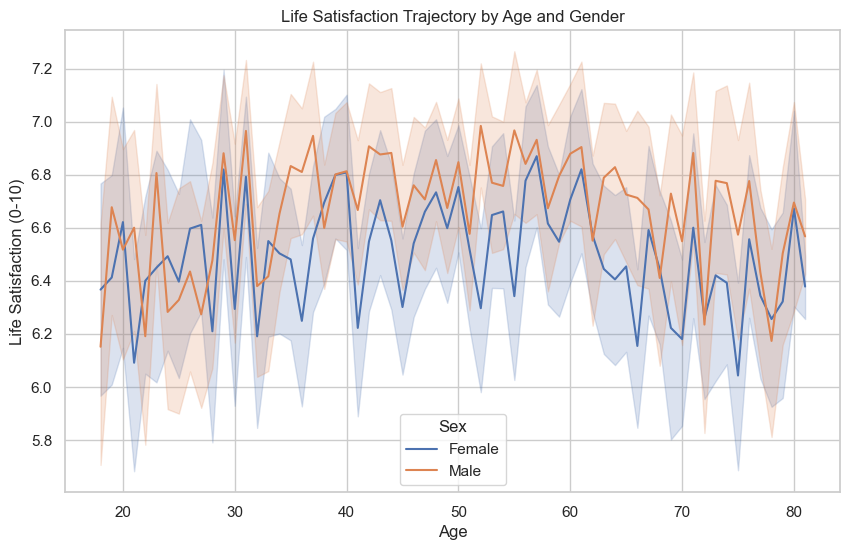

<Figure size 1000x600 with 0 Axes>

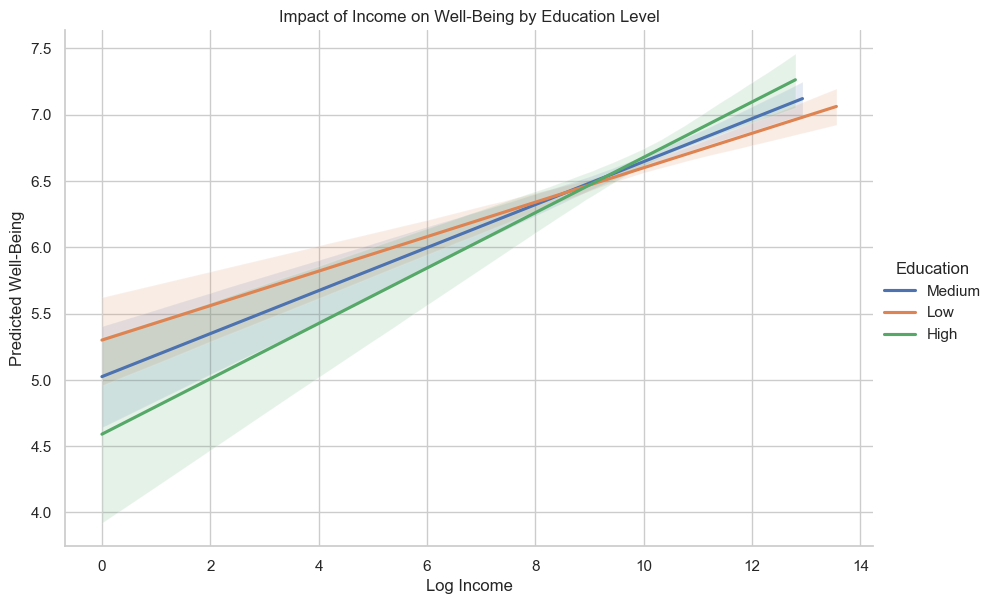

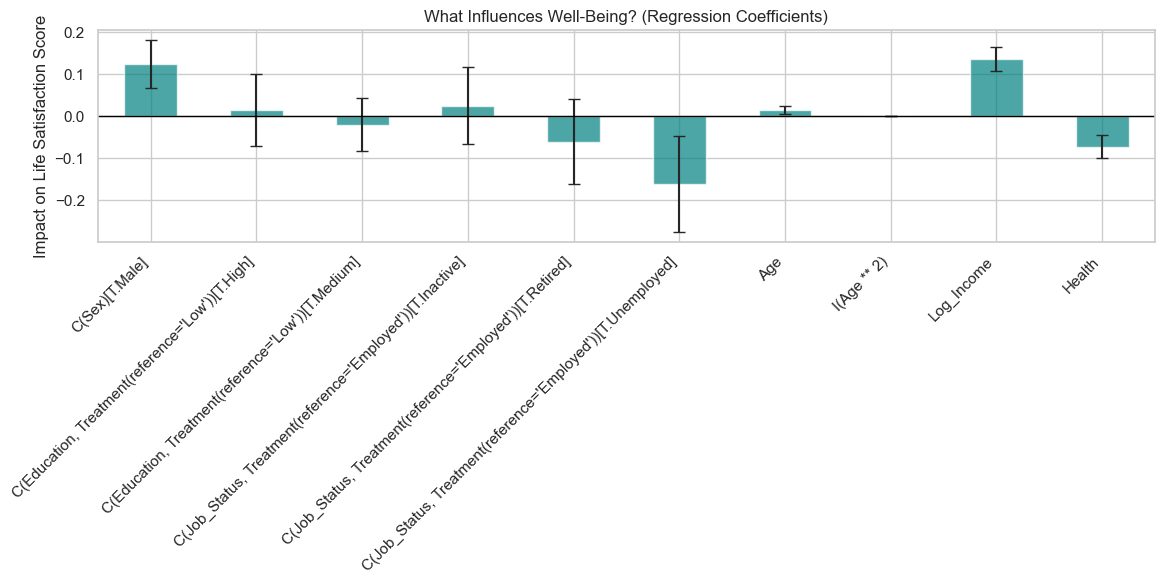

In [3]:
# Set the visual style
sns.set_theme(style="whitegrid")

# --- Plot 1: The Happiness "Hill" (Age vs WellBeing by Sex) ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_clean, x='Age', y='WellBeing', hue='Sex', 
             estimator='mean', ci=95)
plt.title('Life Satisfaction Trajectory by Age and Gender')
plt.ylabel('Life Satisfaction (0-10)')
plt.show()

# --- Plot 2: Income x Education Interaction ---
# Does money buy as much happiness for the highly educated vs less educated?
plt.figure(figsize=(10, 6))
sns.lmplot(data=df_clean, x='Log_Income', y='WellBeing', hue='Education', 
           scatter=False, height=6, aspect=1.5)
plt.title('Impact of Income on Well-Being by Education Level')
plt.ylabel('Predicted Well-Being')
plt.xlabel('Log Income')
plt.show()

# --- Plot 3: Coefficient "Ladder" ---
# Visualizing what matters most (Effect Sizes)
# Extract coefficients, drop Intercept
coefs = model.params.drop('Intercept')
errors = model.bse.drop('Intercept')

plt.figure(figsize=(12, 6))
coefs.plot(kind='bar', yerr=errors * 1.96, capsize=4, color='teal', alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.title('What Influences Well-Being? (Regression Coefficients)')
plt.ylabel('Impact on Life Satisfaction Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
df_clean['PD030'].value_counts()

PD030
1    20568
2     1463
3     1124
Name: count, dtype: int64

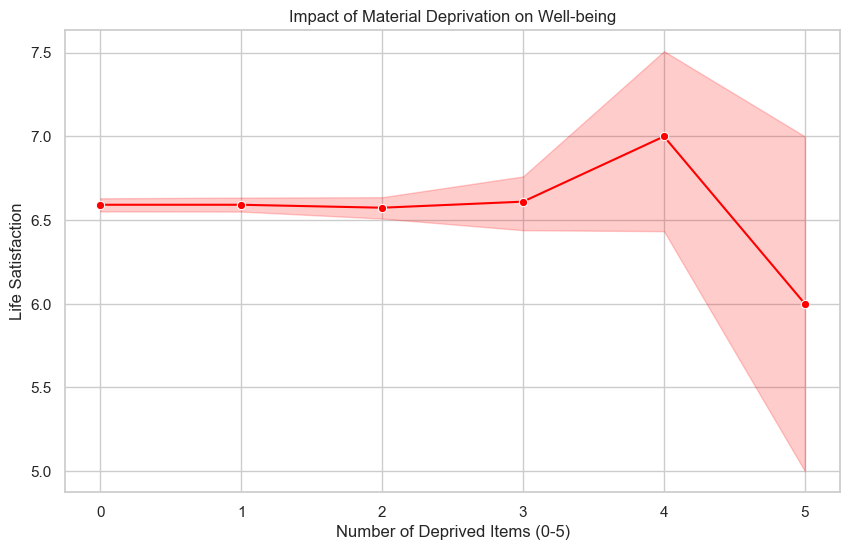

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('IT_2013p_EUSILC.csv')
df_clean = df.copy()
df_clean['Life_Sat'] = df_clean['PW010'].replace(99, np.nan) # Target

# 3. Material Deprivation Index (PD Variables)
# Count how many items (Clothes, Shoes, Leisure) the person "Cannot Afford" (Code 2)
dep_vars = ['PD020', 'PD030', 'PD050', 'PD060', 'PD070']
# Create binary flags (1 if Deprived, 0 otherwise)
for col in dep_vars:
    df_clean[f'{col}_Deprived'] = (df_clean[col] == 2).astype(int)

df_clean['Deprivation_Index'] = df_clean[[f'{c}_Deprived' for c in dep_vars]].sum(axis=1)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Deprivation_Index', y='Life_Sat', data=df_clean, marker='o', color='red')
plt.title('Impact of Material Deprivation on Well-being')
plt.xlabel('Number of Deprived Items (0-5)')
plt.ylabel('Life Satisfaction')
plt.show()